In [2]:
import baseprocess as bp
import yaml
import src.utilities as utl
from plxscripting.easy import new_server
from src.geoplot import GEOPlot
import  plotly.graph_objects as go
from model import *

In [3]:
# !pip install plxscripting
# !pip install setuptools
#!pip install PyPDF2

In [4]:
water_level=1.0
width = 0.67
material_name = 'Soft_Soil'
thk = 4
seabed = -3
applied_load=20
plaxis_path = r'C:\Program Files\Bentley\Geotechnical\PLAXIS 2D CONNECT Edition V22'
# password = "Nv~?e5x5i32u#X/A"
password = "%ufyhg5TSV1tN!3m"
proj = bp.BaseProject(openplaxis=False,plaxis_path=plaxis_path,password=password)
proj.new_2Dproject(xmin_ip=0,xmax_ip=1,ymin_ip=-8,ymax_ip=0,project_title="Consolidation Analysis",usr_comment='')

2024-05-07 16:22:12,551 [MainThread  ] [INFO ]  Plaxis connection established...


## Build Materils below

In [5]:
g_i = proj._g_i
proj.delete_all_materials()

x = utl.read_input_file('material.yaml')

for material_name in x:
    # material_name = 'Mohr_Coulomb'
    m_sand= x[material_name]
    material = g_i.soilmat()
    mat = material.setproperties(*flatten_dict(m_sand))
    material.Identification = material_name
m_plate = g_i.platemat()
m_plate.setproperties('MaterialType','Elastic',
                      'EA1',1e8,
                      'EI',1e8,
                      'StructNu',0.45,
                     'Identification', "dummy_plate")


'PlateMat_1 renamed to Dummy_plate'

# Build Model below

In [6]:
g_i = proj._g_i
g_i.gotosoil()
proj.delete_all_bh()
bh = g_i.borehole(0)
bh.Head=water_level
width = width
seabed = seabed
thk = thk
applied_load = applied_load
g_i.SoilContour.initializerectangular(0, seabed-thk, width, seabed)
g_i.soillayer(-seabed+thk)
g_i.Soillayers[-1].Zones[0].Top=seabed
g_i.Soils[0].Material =getattr(g_i,material_name) 
g_i.gotostructures()
line_load = g_i.lineload((0, seabed), (width, seabed))
line_load[-1].q_start = applied_load
plate = g_i.plate(line_load[-2])
plate.Material=g_i.Dummy_plate
x = g_i.drain((0,seabed),(0,seabed-thk))
g_i.gotomesh()
g_i.mesh(0.05)

# set flow condition
g_i.gotoflow()
g_i.Drains[0].h[g_i.InitialPhase] =1
g_i.activate([g_i.GWFlowBaseBC_3,g_i.GWFlowBaseBC_2],g_i.InitialPhase)
g_i.GWFlowBaseBC_3.Behaviour[g_i.InitialPhase] = 'closed'
g_i.GWFlowBaseBC_2.Behaviour[g_i.InitialPhase] = 'closed'
water_level = g_i.waterlevel((-3,1),(10,1))
g_i.setglobalwaterlevel(water_level, g_i.InitialPhase)

2024-05-07 16:22:32,932 [MainThread  ] [INFO ]  No BH information in Plaxis Model


'OK'

In [ ]:
output_port = g_i.view(g_i.Phase[-1])
_, g_o = new_server('localhost', output_port, password=password) 
g_i.calculate()
filename = f'{material_name}-thk={thk}-width={width}'
# post_process(proj,file

In [ ]:

output_port = g_i.selectmeshpoints() 
_, g_o = new_server('localhost', output_port, password=password)
g_o.addcurvepoint('node', g_o.Soil_1_1, (width/2, seabed))

In [5]:


build_materials(proj)
build_model(proj,water_level=water_level,
            width=width,
            seabed=seabed,
            thk=thk,
            applied_load=applied_load,
            material_name=material_name)
build_stages(proj)
output_port = g_i.view(g_i.Phase[-1])
_, g_o = new_server('localhost', output_port, password=password) 
g_i.calculate()
filename = f'{material_name}-thk={thk}-width={width}'
post_process(proj,filename)

2024-04-30 23:40:15,557 [MainThread  ] [INFO ]  Launching Plaxis, it may take a minute...
2024-04-30 23:40:32,484 [MainThread  ] [INFO ]  No BH information in Plaxis Model


NameError: name 'g_i' is not defined

In [4]:
def post_process(proj,filename):
    df = pd.DataFrame()
    ix = 0
    for phase in g_o.Phases:
        if phase.Name.value =='InitialPhase':
            pass
        else:
            for step in phase.Steps:
                val = g_o.getcurveresults(g_o.Curvepoints.Nodes[0],step, g_o.ResultTypes.Soil.Utot)
                df.loc[ix,'y'] = val
                df.loc[ix,'time'] = step.Reached.Time.value
                ix+=1
    fig = GEOPlot.get_figure()
    fig.add_trace(go.Scatter(x=df.time,y=df.y*1000,line=dict(color='black')))
    fig.update_layout(width=800,height=400)
    fig.update_yaxes(range=[200,0],title='Consolidation Settlement (mm)')
    fig.update_layout(xaxis_type='log')
    df.to_json(filename+'.json')
    fig.write_html(filename+'.html')
def build_materials(proj,filename='./material.yaml'):

def build_model(proj,
                water_level, 
                width, 
                seabed,
                thk,
                applied_load,material_name):
    g_i = proj._g_i
    g_i.gotosoil()
    proj.delete_all_bh()
    bh = g_i.borehole(0)
    bh.Head=water_level
    width = width
    seabed = seabed
    thk = thk
    applied_load = applied_load
    g_i.SoilContour.initializerectangular(0, seabed-thk, width, seabed)
    g_i.soillayer(-seabed+thk)
    g_i.Soillayers[-1].Zones[0].Top=seabed
    g_i.Soils[0].Material =getattr(g_i,material_name) 
    g_i.gotostructures()
    line_load = g_i.lineload((0, seabed), (width, seabed))
    line_load[-1].q_start = applied_load
    x = g_i.drain((0,seabed),(0,seabed-thk))
    g_i.gotomesh()
    g_i.mesh(0.05)

    # set flow condition
    g_i.gotoflow()
    g_i.Drains[0].h[g_i.InitialPhase] =1
    g_i.activate([g_i.GWFlowBaseBC_3,g_i.GWFlowBaseBC_2],g_i.InitialPhase)
    g_i.GWFlowBaseBC_3.Behaviour[g_i.InitialPhase] = 'closed'
    g_i.GWFlowBaseBC_2.Behaviour[g_i.InitialPhase] = 'closed'
    water_level = g_i.waterlevel((-3,1),(10,1))
    g_i.setglobalwaterlevel(water_level, g_i.InitialPhase)

def build_stages(proj, step_size = 2, n_step=10):
    # Construct Stages
    g_i = proj._g_i
    g_i.gotostages()
    n_stage = n_step
    for i in range(1,n_stage):
        this_phase = g_i.phase(g_i.Phases[-1])
        this_phase.Identification = 'Consolidation'
        this_phase.DeformCalcType = 'Consolidation'
        this_phase.TimeInterval = step_size**i
        this_phase.Identification = f'Consolidation at {2**i} days'
        g_i.LineLoads[0].Active[this_phase] = True
        g_i.activate(g_i.Drains, this_phase)
        g_i.activate(g_i.GroundwaterFlowBCs, this_phase)
        
    output_port = g_i.selectmeshpoints() 
    _, g_o = new_server('localhost', output_port, password=password)
    g_o.addcurvepoint('node', g_o.Soil_1_1, (width/2, seabed))
    g_o.update()
    g_i.calculate()

In [30]:
g_i.view(g_i.Phases[-1])
g_o.getcurveresults(g_o.Curvepoints.Nodes.value[0],g_o.Phases[1],g_o.ResultTypes.Soil.Utot)

0.0382788201363464

In [31]:
import pandas as pd
df = pd.DataFrame()
ix = 0
for phase in g_o.Phases:
    if phase.Name.value =='InitialPhase':
        pass
    else:
        for step in phase.Steps:
            val = g_o.getcurveresults(g_o.Curvepoints.Nodes[0],step, g_o.ResultTypes.Soil.Utot)
            df.loc[ix,'y'] = val
            df.loc[ix,'time'] = step.Reached.Time.value
            ix+=1

In [32]:
fig = GEOPlot.get_figure()
fig.add_trace(go.Scatter(x=df.time,y=df.y*1000,line=dict(color='black')))
fig.update_layout(width=800,height=400)
fig.update_yaxes(range=[200,0],title='Consolidation Settlement (mm)')
filename=f'Trial_{applied_load}-{width}-{thk}'
fig.update_layout(xaxis_type='log')
df.to_json(filename+'.json')
fig.write_html(filename+'.html')

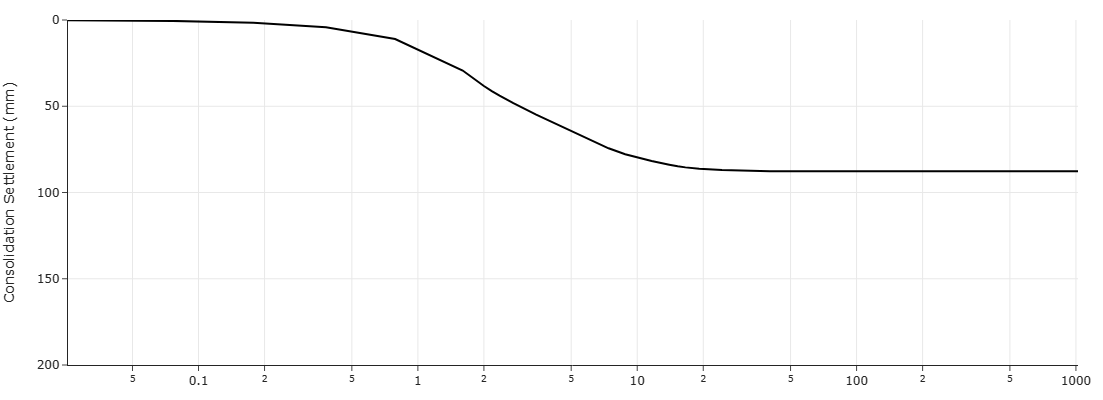

In [33]:
fig

In [9]:
proj.s_i.close()

'OK'

In [13]:
from pathlib import Path
from src.geoplot import GEOPlot
import plotly.graph_objects as go
import json
import pandas as pd

In [5]:
output_path = Path('output')

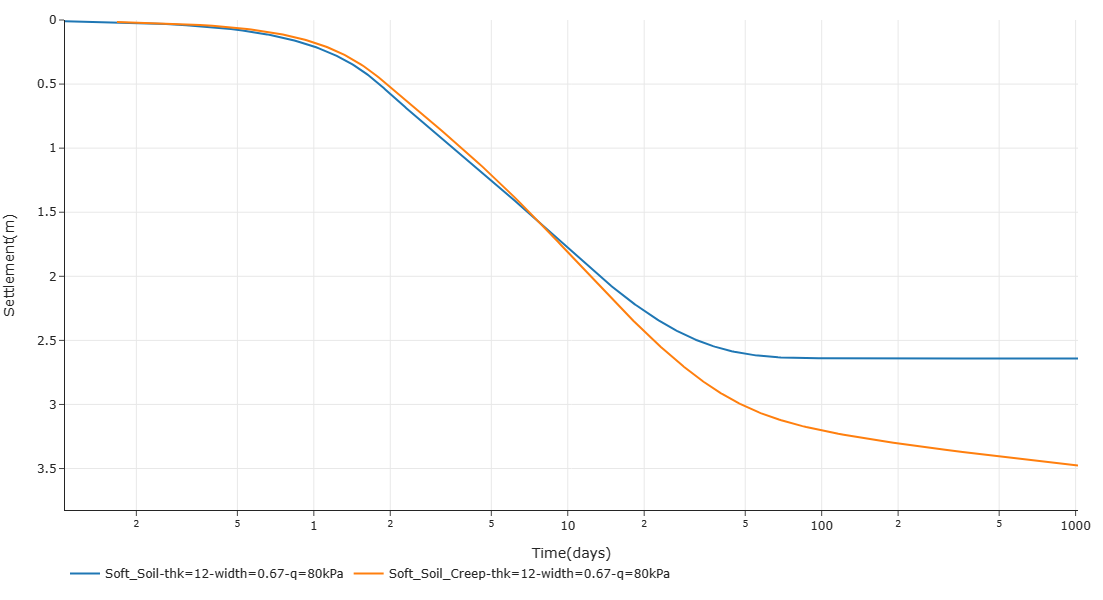

In [43]:
fig = GEOPlot.get_figure()
for file in output_path.glob('*thk=12-width=0.67-q=80kPa.json'):
    with open(file) as fin:
        data = json.load(fin)
        df = pd.DataFrame(data)
    fig.add_trace(go.Scatter(x=df.time, y=df.y,name=file.stem))
fig.update_xaxes(type='log',title='Time(days)')
fig.update_yaxes(range=[df.y.max()*1.1, 0],title = 'Settlement(m)')
fig.update_layout(width=1000,height=600,legend=dict(orientation='h'))

In [21]:
df

,y,time
0,0.015394,0.167717
1,0.024810,0.251575
2,0.029940,0.293505
3,0.032564,0.314469
4,0.038476,0.356399
...,...,...
346,3.417079,562.377600
347,3.426032,614.806400
348,3.441690,719.664000
349,3.455051,824.521600


In [42]:
GEOPlot.get_figure?

Signature:
GEOPlot.get_figure(
    size='A4',
    orientation='v',
    transparent=False,
    cols=1,
    rows=1,
    logo=True,
    footer=None,
)
Docstring: <no docstring>
File:      c:\users\dell\onedrive\documents\desktop\unitcpt\src\geoplot.py
Type:      method